In [328]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from sklearn.model_selection import KFold

learningRate = 1
degree=6
k_splits=10

def loaddata(path):
    data=pd.read_csv(path,header=None,sep = "\t",names=['y','x1','x2'])[1:]
    return data

def clip_data(data):
    x1 = data['x1']
    x2 = data['x2']
    y =data['y']
    x1=pd.to_numeric(x1)
    x2=pd.to_numeric(x2)
    y=pd.to_numeric(y)
    return y,x1,x2

def feature_mapping_plus(x1,x2,degree):
    data = pd.DataFrame()
    data['常数项']=None
    for i in range(1,degree+1):#从1取到degree
        for j in range(0,i+1):
            data['F'+str(i-j) + str(j)] = np.power(x1,i-j) * np.power(x2,j)
    data['常数项']=1
    return data 

def txt2data(path,degree):
    data=loaddata(path)
    y,x1,x2=clip_data(data)
    data=feature_mapping_plus(x1,x2,degree)
    
    return data,y

def data_factory(path_train,path_test,degree):
    train_data,train_label = txt2data(path_train,degree)
    test_data,test_label = txt2data(path_test,degree)
    x_train = np.array(train_data.values)
    x_test = np.array(test_data.values)

    y_train = np.array(train_label.values)
    y_test = np.array(test_label.values)

    n,m = np.shape(train_data)
    theta =np.mat(np.ones((m,1)))
    return train_data,train_label,test_data,test_label,x_train,x_test,y_train,y_test,theta


    
def plotData(data, X_labels,y_table):
    positive = data[data[y_table].isin([1])]
    negative = data[data[y_table].isin([0])]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(positive[X_labels[0]], positive[X_labels[1]], c='r', marker='o', label='Admitted')
    ax.scatter(negative[X_labels[0]], negative[X_labels[1]], c='b', marker='x', label='Rejected')
    ax.legend()
    ax.set_xlabel(X_labels[0] + ' Score')
    ax.set_ylabel(X_labels[1] + ' Score')
    #plt.title(tr_or_ts)
'''''
def feature_mapping(X1, X2, degree):
    data = pd.DataFrame()
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            data['F' + str(i-j) + str(j)] = np.power(X1, i - j) * np.power(X2, j)
    return data
'''
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

def predict(theta, X):
    #probability = sigmoid(X * theta.T)
    probability = sigmoid(X * theta)
    return [1 if x >= 0.5 else 0 for x in probability]


def costReg(theta, x, y, learningRate):
    theta = np.matrix(theta)

    X = np.matrix(x)
    y = np.matrix(y).T
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

def gradientReg(theta, x, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(x)
    y = np.matrix(y).T

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for j in range(parameters):
        term = np.multiply(error, X[:, j])

        if j == 0:
            grad[j] = np.sum(term) / len(X)
        else:
            grad[j] = (np.sum(term)) / len(X) + ((learningRate / len(x)) * theta[:, j])
    return grad



def find_decision_boundary(density, degree, theta, threshold, cord_bounds):
    t1 = np.linspace(cord_bounds[0], cord_bounds[1], density)
    t2 = np.linspace(cord_bounds[2], cord_bounds[3], density)

    coordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*coordinates)
    mapped_cord = feature_mapping_plus(x_cord, y_cord, degree)

    inner_product = np.matrix(mapped_cord) * theta.T
    decision = mapped_cord[np.abs(inner_product) < threshold]

    return decision.F10, decision.F01

def draw_boundary(data, degree, theta, x_label, y_label, cord_bounds,tr_or_ts):
    density = 1000
    threshold = 2 * 10 ** -3

    x, y = find_decision_boundary(density, degree, theta, threshold, cord_bounds)


    plotData(data, x_label,y_label)
    plt.scatter(x, y, c='g', s=10)
    plt.title(tr_or_ts)

def data_for_draw(data,label):
    data1=pd.DataFrame()
    data1['y']=label
    data1['X1']=data.F10
    data1['X2']=data.F01
    #plotData(data1,['X1','X2'],'y')
    return data1

def draw_double_boundary(lamb,train_scarrer,test_scarrer,degree,x_train, y_train):
    train_results = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(x_train, y_train, lamb))
    draw_boundary(train_scarrer, degree, np.matrix(train_results[0]), ['X1', 'X2'], 'y', [-1, 1.5, -1, 1.5],'train')
    draw_boundary(test_scarrer, degree, np.matrix(train_results[0]), ['X1', 'X2'], 'y', [-1, 1.5, -1, 1.5],'test')
    plt.show()

def Train_results(lambdas,x_train,y_train):
    train_results = []
    for i in lambdas:
        train_results.append(opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(x_train, y_train, i)))
        TRAIN_result= [train_results[i][0] for i in range(len(train_results))]
    return TRAIN_result,train_results

def double_accuracy(TRAIN_result,x_train,y_train,x_test,y_test):
    train_accuracy=[]
    test_accuracy=[]
    for i in range(len(train_results)):
        A=np.matrix(TRAIN_result[i])
        predictions= predict(A.T,x_train)
        correct = [1 if ((a==1 and b== 1)or(a==0 and b== 0)) else 0 for (a,b)
         in zip(predictions,y_train) ]
        accuracy= (sum(map(int,correct))/len(correct)) 
        train_accuracy.append(accuracy)

        predictions_2= predict(A.T,x_test)
        correct_1 = [1 if ((a==1 and b== 1)or(a==0 and b== 0)) else 0 for (a,b) in zip(predictions_2,y_test) ]
        accuracy_1= (sum(map(int,correct_1))/len(correct_1)) 
        test_accuracy.append(accuracy_1)
    return train_accuracy,test_accuracy

def Acc(fold_results,x_test_f,y_test_f):
    fold_accuracy=[]
    for j in range(len(fold_results)):
        A= np.matrix(fold_results[j][0])
        fold_predictions = predict(A.T, x_test_f)
        train_correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in
                         zip(fold_predictions, y_test_f)]
        fold_accuracy.append(sum(map(int,train_correct)) / len(train_correct))
    return fold_accuracy

def k_fc(k,x_train,y_train):
    kf = KFold(n_splits=k)
    fold_accuracies = []
    for train, test in kf.split(x_train):
        x_train_f=x_train[train]
        y_train_f=y_train[train]
        x_test_f=x_train[test]
        y_test_f=y_train[test]
        FOLRD_result,fold_results=Train_results(lambdas,x_train_f,y_train_f)
        fold_accuracy= Acc(fold_results,x_test_f,y_test_f)
        fold_accuracies.append(fold_accuracy)
        fold_results.clear()
    fc_mean = np.mean(fold_accuracies, 0)
    return fc_mean

In [329]:
#生成需要用到的数据
#基础数据
train_data,train_label,test_data,test_label,\
    x_train,x_test,y_train,y_test,theta=data_factory('train.txt','test.txt',degree)
#散点图数据
train_scarrer=data_for_draw(train_data,train_label)
test_scarrer=data_for_draw(test_data,test_label)
# lambdas & log_lambds 数据
lambdas = list(np.array(pd.read_csv('lambda.txt', header=None).values).flatten())
log_lambdas = [np.log10(i) for i in lambdas]
#训练后的参数  数据
TRAIN_result,train_results = Train_results(lambdas,x_train,y_train)
#正确率结果  数据
train_accuracy,test_accuracy=double_accuracy(TRAIN_result,x_train,y_train,x_test,y_test)
#k折交叉验证数据
fc_mean=k_fc(k_splits,x_train,y_train)

C:\Users\MR\AppData\Local\Temp/ipykernel_11816/3539097478.py:89: RuntimeWarning: divide by zero encountered in log
  second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
C:\Users\MR\AppData\Local\Temp/ipykernel_11816/3539097478.py:89: RuntimeWarning: invalid value encountered in multiply
  second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))


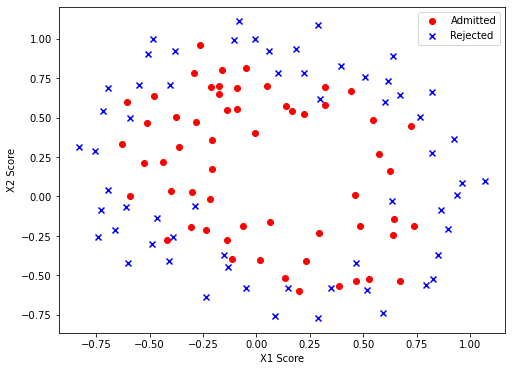

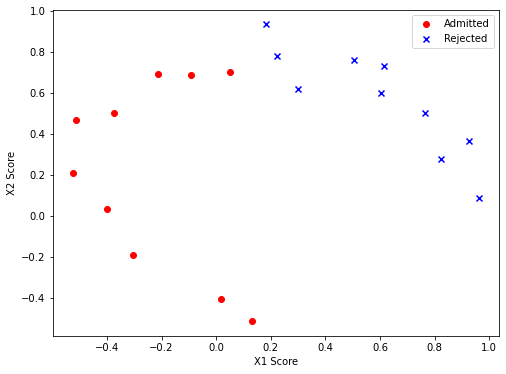

In [330]:
#数据散点图
plotData(train_scarrer,['X1','X2'],'y')
plotData(test_scarrer,['X1','X2'],'y')

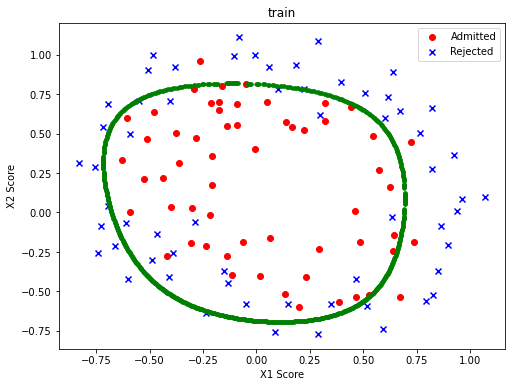

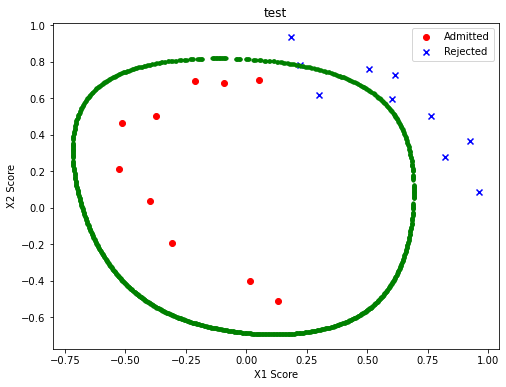

In [337]:
#lambda=20时在测试集和训练集的分类边界
draw_double_boundary(5,train_scarrer,test_scarrer,degree,x_train, y_train)#lambda=20

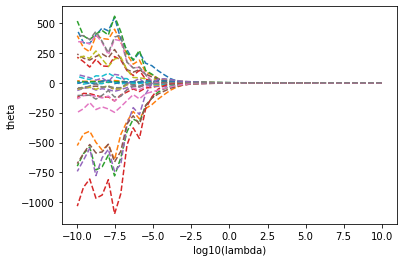

In [332]:
#参数theta随lambda变化
plt.plot(log_lambdas, TRAIN_result, linestyle='--')
plt.xlabel('log10(lambda)')
plt.ylabel('theta')
plt.show()

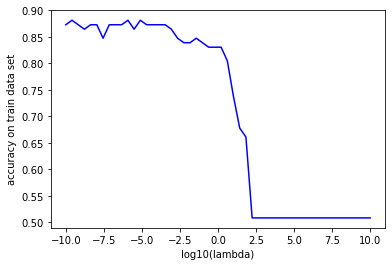

In [333]:
#训练集正确率
plt.plot(log_lambdas, train_accuracy, c='b')
plt.xlabel('log10(lambda)')
plt.ylabel('accuracy on train data set')
plt.show()

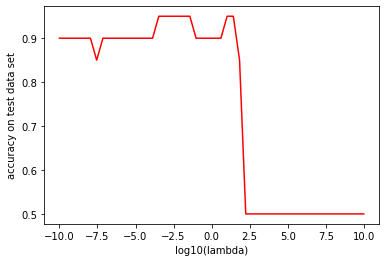

In [334]:
#测试集正确率
plt.plot(log_lambdas, test_accuracy, c='r')
plt.xlabel('log10(lambda)')
plt.ylabel('accuracy on test data set')
plt.show()

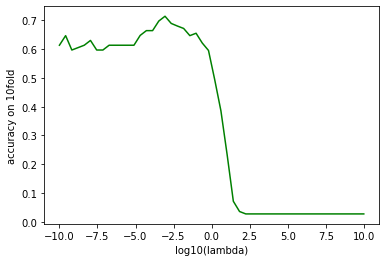

In [335]:
#k折交叉验证
plt.plot(log_lambdas, fc_mean, c='g')
plt.xlabel('log10(lambda)')
plt.ylabel('accuracy on 10fold')
plt.show()


In [339]:
Max_train = max(train_accuracy)
Max_test = max(test_accuracy)
index_train=train_accuracy.index(Max_train)
index_test=test_accuracy.index(Max_test)

print('learningRate = {0},degree={1}'.format(learningRate,degree))
print('在训练集上，当lambda={0}时，正确率最高为{1}%\n而此时在测试集上的正确率为{2}%'\
    .format(lambdas[index_train],Max_train*100,test_accuracy[index_train]*100))
print('在测试集上，当lambda={0}时，正确率最高为{1}%\n而此时在训练集上的正确率为{2}%'\
    .format(lambdas[index_test],Max_test*100,train_accuracy[index_test]*100))


learningRate = 1,degree=6
在训练集上，当lambda=7.9060432109077e-06时，正确率最高为88.13559322033898%
而此时在测试集上的正确率为90.0%
在测试集上，当lambda=26.8269579527973时，正确率最高为95.0%
而此时在训练集上的正确率为67.79661016949152%
